In [1]:
import pandas as pd
import numpy as np

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

#metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from collections import defaultdict


#processing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

A little investigation

In [2]:
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


The columns rownumber, customerid and surname I do not need, no extra info, can drop them

In [4]:
df1.drop(columns=['Surname','RowNumber','CustomerId'],inplace=True)

Lets check for nulls

In [5]:
df1.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [6]:
df1['Tenure'] = df1['Tenure'].fillna(0)

In [7]:
df1.columns = df1.columns.str.lower()
df1.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [8]:
df1.dtypes

creditscore          int64
geography           object
gender              object
age                  int64
tenure             float64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
exited               int64
dtype: object

To work with classifications I have to get rid from the object columns, will use get_dummies

In [9]:
df1 = pd.get_dummies(df1,drop_first=True)
df1.shape

(10000, 12)

Model Preparations

In [11]:
df, df_test = train_test_split(df1, test_size=0.20, random_state=12345)

In [12]:
X_test = df_test[df_test.columns.difference(['exited'])]
y_test = df_test['exited']

In [13]:
X = df[df.columns.difference(['exited'])]
y = df['exited']
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.20, random_state=12345)

Logistic

In [14]:
model = LogisticRegression(solver='liblinear',class_weight='balanced')
model.fit(X_train, y_train)
print(f'F1 score for train:{f1_score(y_train, model.predict(X_train))}')
print(f'F1 score for valid:{f1_score(y_valid, model.predict(X_valid))}')

F1 score for train:0.47934322033898313
F1 score for valid:0.45414847161572064


LGB

In [15]:
model = LGBMClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train,verbose=1)
predict = model.predict(X_valid)
print(f'F1 score for train:{f1_score(y_train, model.predict(X_train))}')
print(f'F1 score for valid:{f1_score(y_valid, model.predict(X_valid))}')

F1 score for train:0.8083832335329342
F1 score for valid:0.5974395448079658


DT

In [16]:
d = defaultdict(list)
for depth in range(1,20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345,class_weight='balanced')
    model.fit(X_train,y_train)
    d['depth'].append(depth)
    d['f1_train'].append(f1_score(y_train, model.predict(X_train)))
    d['f1_valid'].append(f1_score(y_valid, model.predict(X_valid)))
pd.DataFrame(d).sort_values(by='f1_valid',ascending=False).head()

,depth,f1_train,f1_valid
5,6,0.603156,0.555276
6,7,0.622275,0.545455
4,5,0.578565,0.544554
7,8,0.648959,0.543837
3,4,0.550490,0.525031


RF - 1 to 42 trees

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
d = defaultdict(list)
for estim in range(1,42):
    for depth in range(1,15):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth,random_state=12345)
        model.fit(X_train,y_train)
        predict = model.predict(X_valid)
        d['estim'].append(estim)
        d['depth'].append(depth)
        d['f1_train'].append(f1_score(y_train, model.predict(X_train)))
        d['f1_valid'].append(f1_score(y_valid, predict))
pd.DataFrame(d).sort_values(by='f1_valid',ascending=False).head()

,estim,depth,f1_train,f1_valid
391,28,14,0.915184,0.607004
363,26,14,0.913007,0.605469
307,22,14,0.910825,0.605010
335,24,14,0.911350,0.600775
377,27,14,0.911582,0.600000


RF - 50 to 100 trees

In [20]:
d = defaultdict(list)
for estim in range(50,100):
    for depth in range(1,15,2):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth,random_state=12345)
        model.fit(X_train,y_train)
        predict = model.predict(X_valid)
        d['estim'].append(estim)
        d['depth'].append(depth)
        d['f1_train'].append(f1_score(y_train, model.predict(X_train)))
        d['f1_valid'].append(f1_score(y_valid, predict))
pd.DataFrame(d).sort_values(by='f1_valid',ascending=False)

,estim,depth,f1_train,f1_valid
258,86,13,0.858011,0.576687
272,88,13,0.857019,0.575510
342,98,13,0.859870,0.574338
328,96,13,0.862338,0.574338
251,85,13,0.858507,0.573770
...,...,...,...,...
196,78,1,0.000000,0.006579
189,77,1,0.000000,0.006579
182,76,1,0.000000,0.006579
168,74,1,0.000000,0.006579


I will try with scaling to see if I can get some better results

In [21]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Logistic

In [22]:
model = LogisticRegression(solver='liblinear',class_weight='balanced')
model.fit(X_train, y_train)
print(f'F1 score for train:{f1_score(y_train, model.predict(X_train))}')
print(f'F1 score for valid:{f1_score(y_valid, model.predict(X_valid))}')

F1 score for train:0.49618736383442263
F1 score for valid:0.4673539518900344


LGB

In [23]:
model = LGBMClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train,verbose=1)
print(f'F1 score for train:{f1_score(y_train, model.predict(X_train))}')
print(f'F1 score for valid:{f1_score(y_valid, model.predict(X_valid))}')

F1 score for train:0.8013245033112583
F1 score for valid:0.598581560283688


DT

In [24]:
d = defaultdict(list)
for depth in range(1,20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345,class_weight='balanced')
    model.fit(X_train,y_train)
    d['depth'].append(depth)
    d['f1_train'].append(f1_score(y_train, model.predict(X_train)))
    d['f1_valid'].append(f1_score(y_valid, model.predict(X_valid)))
pd.DataFrame(d).sort_values(by='f1_valid',ascending=False).head()

,depth,f1_train,f1_valid
5,6,0.603156,0.555276
6,7,0.622275,0.545455
4,5,0.578565,0.544554
7,8,0.648959,0.543837
3,4,0.550490,0.525031


RF - 1 to 42 trees

In [25]:
d = defaultdict(list)
for estim in range(1,42):
    for depth in range(1,15):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth,random_state=12345)
        model.fit(X_train,y_train)
        predict = model.predict(X_valid)
        d['estim'].append(estim)
        d['depth'].append(depth)
        d['f1_train'].append(f1_score(y_train, model.predict(X_train)))
        d['f1_valid'].append(f1_score(y_valid, predict))
pd.DataFrame(d).sort_values(by='f1_valid',ascending=False).head()

,estim,depth,f1_train,f1_valid
391,28,14,0.914735,0.606654
307,22,14,0.910825,0.605825
363,26,14,0.912557,0.605108
335,24,14,0.911350,0.601562
377,27,14,0.911582,0.601179


RF - 50 to 100 trees

In [26]:
d = defaultdict(list)
for estim in range(50,100):
    for depth in range(1,15,2):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth,random_state=12345)
        model.fit(X_train,y_train)
        predict = model.predict(X_valid)
        d['estim'].append(estim)
        d['depth'].append(depth)
        d['f1_train'].append(f1_score(y_train, model.predict(X_train)))
        d['f1_valid'].append(f1_score(y_valid, predict))
pd.DataFrame(d).sort_values(by='f1_valid',ascending=False)

,estim,depth,f1_train,f1_valid
272,88,13,0.857515,0.579592
258,86,13,0.859002,0.579592
300,92,13,0.861472,0.575510
286,90,13,0.858384,0.575510
328,96,13,0.861845,0.575510
...,...,...,...,...
196,78,1,0.000000,0.006579
189,77,1,0.000000,0.006579
182,76,1,0.000000,0.006579
168,74,1,0.000000,0.006579


Conclusion:

Between logistic and LGB I can clearly see that LGB gives a better result.<br>
DT - best result was depth 6 with out scaling and result looked the same with scaling <br>
RF - best result was 28 estim and depth 14 with scaling and without, same result<br>

I will check test for LGB and RF with 28 estim and depth 14

Checking test:

In [27]:
model = LGBMClassifier(class_weight='balanced', random_state=12345)
model.fit(X_train, y_train,verbose=1)
print(f'F1 score for test:{f1_score(y_test, model.predict(X_test))}')

F1 score for test:0.645367412140575


In [28]:
model = RandomForestClassifier(n_estimators=28, max_depth=14,random_state=12345)
model.fit(X_train,y_train)
print(f'F1 score for test:{f1_score(y_test, model.predict(X_test))}')

F1 score for test:0.5647743813682679


Final results:

I can see that LGB gave me the wanted results and passed the 0.59 F1 score needed and managed to get 0.64

Checking ROC:

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

In [30]:
probs = model.predict_proba(X_test)
probs_one = probs[:,1]

In [31]:
auc_roc = roc_auc_score(y_test, probs_one)
print(auc_roc)

0.8542895256755167


In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, probs_one)

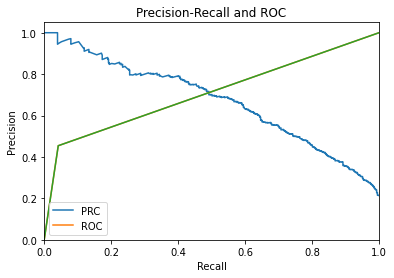

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))

plt.plot(recall, precision, label='PRC')
plt.plot(fpr, tpr, label='ROC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall and ROC')
plt.legend(loc="lower left")

plt.plot(fpr, tpr)

plt.show()

Final conclusion:


F1 Score keeps a balance between Precision and Recall. We use it if there is uneven class distribution (like in our case its about 4:1), as precision and recall may give misleading results.